# Siamese network
The Cifar-100 dataset is similar to the Cifar-10 dataset. It also consists of 60,000 32x32 RGB images, but they are distributed over 100 classes instead of 10. Thus, each class has much fewer examples, only 500 training images and 100 testing images per class. For more info about the dataset, see https://www.cs.toronto.edu/~kriz/cifar.html.

Training of  a Siamese Network on the first 80 classes of (the training set of) Cifar-100, i.e. let the network predict the probability that two input images are from the same class. Use 1 as a target for pairs of images from the same class (positive pairs), and 0 for pairs of images from different classes (negative pairs). Randomly select image pairs from Cifar-10.

Evaluate the performance of the network on 20-way one-shot learning tasks. Do this by generating 250 random tasks and obtain the average accuracy for each evaluation round. Use the remaining 20 classes that were not used for training. The model should perform better than random guessing.

In [1]:
from keras.layers import Input, Conv2D, Lambda, Dense, Flatten, MaxPooling2D, Dropout, BatchNormalization, merge, concatenate, Activation, Concatenate
from keras.models import Model, Sequential
from keras.layers import LeakyReLU
from keras.regularizers import l2
from keras import backend as K
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.datasets import cifar100
from keras.losses import binary_crossentropy
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.initializers import TruncatedNormal, RandomNormal

import numpy as np
import os
import pickle
from itertools import permutations
import random
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

Using TensorFlow backend.


In [0]:
# load data
from keras.datasets import cifar100

# we are only interested in the train data
input_size = (32, 32, 3)
# embedding_dimensions = 128
batch_size = 256
num_classes = 100
num_train_classes = 80
num_test_classes = num_classes - num_train_classes

(cifar_x_train, cifar_y_train), (cifar_x_test, cifar_y_test) = cifar100.load_data(label_mode='fine')

# reshape output labels
cifar_y_train = cifar_y_train.reshape(-1)
cifar_y_test = cifar_y_test.reshape(-1)

In [10]:
print(cifar_x_train.shape)
print(cifar_y_train.shape)
print(cifar_x_test.shape)
print(cifar_y_test.shape)

(50000, 32, 32, 3)
(50000,)
(10000, 32, 32, 3)
(10000,)


In [0]:
#split in training set and validation set and sort by category
# if we sort by category it is simpler to create batch of data
sorted_indices = np.argsort(cifar_y_train)
cifar_x_train = cifar_x_train[sorted_indices]
cifar_y_train = cifar_y_train[sorted_indices]
split_index = np.searchsorted(cifar_y_train, num_train_classes)

In [12]:
x_train = cifar_x_train[:split_index]
y_train = cifar_y_train[:split_index]

# take the last 20 classes as test
x_validation = cifar_x_train[split_index:]
y_validation = cifar_y_train[split_index:]

# NOTE: assumption that the number of samples
#       are divisible by the number of classes
x_train = x_train.reshape(num_train_classes, x_train.shape[0]//num_train_classes, *x_train.shape[1:])
x_validation = x_validation.reshape(num_test_classes, x_validation.shape[0]//num_test_classes, *x_validation.shape[1:])

print(x_train.shape)
print(y_train.shape)
print(x_validation.shape)
print(y_validation.shape)

(80, 500, 32, 32, 3)
(40000,)
(20, 500, 32, 32, 3)
(10000,)


In [0]:
def get_batch(batch_size, X):
    """Create batch of n pairs, half same class, half different class"""
    n_classes, n_examples, w, h, d = X.shape
    # randomly sample several classes to use in the batch
    categories = np.random.choice(n_classes, size=(batch_size,), replace=False)
    # initialize 2 empty arrays for the input image batch
    pairs = [np.zeros((batch_size, h, w, 3)) for i in range(2)]
    # initialize vector for the targets, and make one half of it '1's, so 2nd 
    #half of batch has same class
    targets = np.zeros((batch_size,))
    targets[batch_size//2:] = 1
    for i in range(batch_size):
        category = categories[i]
        idx_1 = np.random.randint(0, n_examples)
        pairs[0][i, :, :, :] = X[category, idx_1].reshape(w, h, 3)
        idx_2 = np.random.randint(0, n_examples)
        # pick images of same class for 1st half, different for 2nd
        if i >= batch_size // 2:
            category_2 = category
        else:
            #add a random number to the category modulo n_classes to ensure 2nd 
            #image has different category
            category_2 = (category + np.random.randint(1,n_classes)) % n_classes
        pairs[1][i, :, :, :] = X[category_2,idx_2].reshape(w, h, 3)
    return pairs, targets

def batch_generator(batch_size, X):
    """a generator for batches, so model.fit_generator can be used. """
    while True:
        pairs, targets = get_batch(batch_size, X)
        yield (pairs, targets)

def train(model, X_train, batch_size=64, steps_per_epoch=625, epochs=1):
    model.fit_generator(batch_generator(batch_size, X_train), 
                        steps_per_epoch=steps_per_epoch, epochs=epochs)

In [15]:
input_shape = (32, 32, 3)
left_input = Input(input_shape)
right_input = Input(input_shape)

# build convnet to use in each siamese 'leg'
convnet = Sequential()

convnet.add(Conv2D(64, (5,5), input_shape=input_shape, kernel_regularizer=l2(2e-4)))
convnet.add(BatchNormalization())
convnet.add(LeakyReLU(alpha=0.1))
convnet.add(MaxPooling2D())

convnet.add(Conv2D(128, (3,3), input_shape=input_shape, kernel_regularizer=l2(2e-4)))
convnet.add(BatchNormalization())
convnet.add(LeakyReLU(alpha=0.1))
convnet.add(MaxPooling2D())

convnet.add(Conv2D(256, (3,3), input_shape=input_shape, padding='SAME', kernel_regularizer=l2(2e-4)))
convnet.add(BatchNormalization())
convnet.add(LeakyReLU(alpha=0.1))

convnet.add(Conv2D(256, (3,3), input_shape=input_shape, padding='SAME', kernel_regularizer=l2(2e-4)))
convnet.add(BatchNormalization())
convnet.add(LeakyReLU(alpha=0.1))

convnet.add(Flatten())

convnet.add(Dense(128, kernel_regularizer=l2(1e-3)))
convnet.summary()

# encode each of the two inputs into a vector with the convnet
encoded_l = convnet(left_input)
encoded_r = convnet(right_input)

# merge two encoded inputs with the L1 distance between them, and connect 
#to prediction output layer
L1_distance = lambda x: K.abs(x[0]-x[1])
both = Lambda(L1_distance)([encoded_l, encoded_r])
prediction = Dense(1, activation='sigmoid')(both)
siamese_net = Model(inputs=[left_input,right_input], outputs=prediction)


optimizer = optimizers.Adam(lr=0.00001)
siamese_net.compile(loss="binary_crossentropy", optimizer=optimizer)


siamese_net.summary()

W0718 14:58:06.599189 140106542684032 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0718 14:58:06.646044 140106542684032 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0718 14:58:06.656705 140106542684032 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0718 14:58:06.706733 140106542684032 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0718 14:58:06.707831 1401065426

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 64)        4864      
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 64)        256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 28, 28, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 128)       73856     
_________________________________________________________________
batch_normalization_2 (Batch (None, 12, 12, 128)       512       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 12, 12, 128)       0         
__________

W0718 14:58:10.747190 140106542684032 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0718 14:58:10.756735 140106542684032 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 128)          2146560     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 128)          0           sequential_1[1][0]               
          

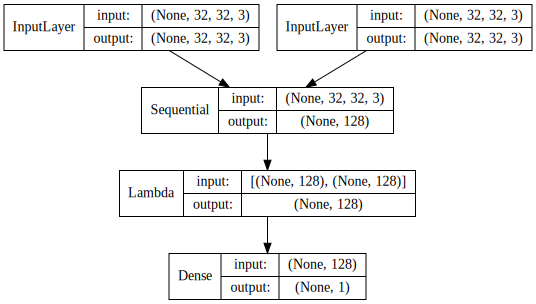

In [16]:
# show model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(siamese_net, show_shapes=True, show_layer_names=False, 
                 rankdir='TB').create(prog='dot', format='svg'))

In [0]:
def make_oneshot_task(N, X):
    """Create pairs of (test image, support set image) with ground truth, for 
    testing N-way one-shot learning."""
    n_classes, n_examples, w, h, d = X.shape
    indices = np.random.randint(0, n_examples, size=(N,))
    
    categories = np.random.choice(range(n_classes), size=(N,), replace=False) 
    
    true_category = categories[0]
    ex1, ex2 = np.random.choice(n_examples, replace=False, size=(2,))
    test_image = np.asarray([X[true_category, ex1, :, :, :]]*N).reshape(N, w, h, 3)
    support_set = X[categories, indices, :, :, :]
    support_set[0, :, :, :] = X[true_category, ex2]
    support_set = support_set.reshape(N, w, h, 3)
    targets = np.zeros((N,))
    targets[0] = 1
    targets, test_image, support_set = shuffle(targets, test_image, support_set)
    pairs = [test_image, support_set]
    return pairs, targets

def test_oneshot(model, X, N=20, k=250, verbose=True):
    """Test average N-way oneshot learning accuracy of a siamese neural net over
    k one-shot tasks."""
    n_correct = 0
    if verbose:
        print("Evaluating model on {} random {}-way one-shot " 
              "learning tasks ...".format(k, N))
    for i in range(k):
        inputs, targets = make_oneshot_task(N, X)
        probs = model.predict(inputs)
        if np.argmax(probs) == np.argmax(targets):
            n_correct += 1
    percent_correct = (100.0*n_correct / k)
    if verbose:
        print("Got an average of {}% accuracy for {}-way one-shot learning"
              .format(percent_correct, N))
    return percent_correct

In [20]:
loops = 100
best_acc = 0
for i in range(loops):
    print("=== Training loop {} ===".format(i+1))
    train(siamese_net, x_train)
    test_acc = test_oneshot(siamese_net, x_validation)
    if test_acc >= best_acc:
        print("********* New best one-shot accuracy, saving model ********")
        siamese_net.save(os.path.join(".", "siamese.h5"))
        best_acc = test_acc

=== Training loop 1 ===
Epoch 1/1
625/625 [==============================] - 15s 24ms/step - loss: 1.0760
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 6.4% accuracy for 20-way one-shot learning
********* New best one-shot accuracy, saving model ********
=== Training loop 2 ===
Epoch 1/1
625/625 [==============================] - 15s 24ms/step - loss: 1.0536
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 10.0% accuracy for 20-way one-shot learning
********* New best one-shot accuracy, saving model ********
=== Training loop 3 ===
Epoch 1/1
625/625 [==============================] - 15s 24ms/step - loss: 1.0382
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 8.4% accuracy for 20-way one-shot learning
=== Training loop 4 ===
Epoch 1/1
625/625 [==============================] - 15s 24ms/step - loss: 1.0241
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an a

In [21]:
print('Best accuracy obtained after',loops,'loops of 1 epoch each:')
print(best_acc)

Best accuracy obtained after 100 loops of 1 epoch each:
20.4
